In [1]:
import numpy as np
import cv2
import pywt
import matplotlib.pyplot as plt

import os
from scipy.fft import dct, idct
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from math import sqrt
from PIL import Image


In [2]:
def similarity(X, X_star):
    # Computes the similarity measure between the original and the new watermarks.
    norm_X = np.sqrt(np.sum(np.multiply(X, X)))
    norm_X_star = np.sqrt(np.sum(np.multiply(X_star, X_star)))

    if norm_X == 0 or norm_X_star == 0:
        return 0.0  # or return 0 or another appropriate value

    s = np.sum(np.multiply(X, X_star)) / (norm_X * norm_X_star)
    return s

def wpsnr(img1, img2):
  img1 = np.float32(img1)/255.0
  img2 = np.float32(img2)/255.0
  difference = img1-img2
  same = not np.any(difference)
  if same is True:
      return 9999999
  w = np.genfromtxt('csf.csv', delimiter=',')
  ew = convolve2d(difference, np.rot90(w,2), mode='valid')
  decibels = 20.0*np.log10(1.0/sqrt(np.mean(np.mean(ew**2))))
  return decibels

In [38]:
#List of different attacks
from sklearn.metrics import roc_curve, auc
from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt
from skimage.transform import rescale
import random

#this seed was set just to make you obtain the same result
random.seed(3)
def awgn(img, std, seed):
  mean = 0.0   # some constant
  #np.random.seed(seed)
  attacked = img + np.random.normal(mean, std, img.shape)
  attacked = np.clip(attacked, 0, 255)
  return attacked

def blur(img, sigma):
  sigma = sigma
  attacked = gaussian_filter(img, [sigma,sigma])
  return attacked

def sharpening(img, sigma, alpha):
  import scipy
  from scipy.ndimage import gaussian_filter
  import matplotlib.pyplot as plt

  #print(img/255)
  filter_blurred_f = gaussian_filter(img, sigma)

  attacked = img + alpha * (img - filter_blurred_f)
  return attacked

def median(img, kernel_size):
  from scipy.signal import medfilt
  attacked = medfilt(img, kernel_size)
  return attacked

def resizing(img, scale):
  x, y = img.shape
  attacked = rescale(img, scale, anti_aliasing=True, mode='reflect')
  attacked = rescale(attacked, 1/scale, anti_aliasing=True, mode='reflect')
  attacked = np.asarray(attacked * 255, dtype=np.uint8)
  attacked = cv2.resize(attacked, (y, x), interpolation=cv2.INTER_LINEAR)

  return attacked

def jpeg_compression(img, QF):
  img = Image.fromarray(img)
  img = img.convert('L')
  img.save('tmp.jpg',"JPEG", quality=QF)
  attacked = Image.open('tmp.jpg')
  attacked = np.asarray(attacked,dtype=np.uint8)
  os.remove('tmp.jpg')

  return attacked

def random_attack(img):
  i = random.randint(1,7)
  if i==1:
    attacked = awgn(img, 10, 123)
    #print("AWGN attack")
  elif i==2:
    attacked = blur(img, 1.2)
    # print("BLUR attack")
  elif i==3:
    attacked = sharpening(img, 1, 1)
    # print("SHARPENING attack")
  elif i==4:
    attacked = median(img, [3, 3])
    # print("MEDIAN attack")
  elif i==5:
    attacked = resizing(img, 0.8)
    # print("RESIZING attack")
  elif i==6:
    attacked = jpeg_compression(img, 75)
    # print("JPEG attack")
  elif i==7:
    attacked = img
    # print("EQUAL attack")

  return attacked

In [29]:
def create_perceptual_mask(image):
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    edges = cv2.magnitude(sobel_x, sobel_y)
    mask = cv2.normalize(edges, None, 0, 1, cv2.NORM_MINMAX)
    mask = cv2.GaussianBlur(mask, (5, 5), 0)
    return mask

def compute_brightness_sensitivity(subband):

    # Normalize brightness between 0 and 1
    min_brightness = np.min(subband)
    max_brightness = np.max(subband)
    brightness_sensitivity = (subband - min_brightness) / (max_brightness - min_brightness + 1e-6)
    
    # Invert to give higher sensitivity in dark areas (lower brightness = higher mask value)
    return 1 - brightness_sensitivity

def compute_edge_sensitivity(subband):

    # Compute image gradient (strong edges correspond to higher gradients)
    sobel_x = cv2.Sobel(subband, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(subband, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalize gradient magnitude between 0 and 1
    gradient_sensitivity = (gradient_magnitude - np.min(gradient_magnitude)) / (np.max(gradient_magnitude) - np.min(gradient_magnitude) + 1e-6)
    
    return gradient_sensitivity

def compute_texture_sensitivity(subband):
    
    # Compute local variance as a measure of texture
    mean = cv2.blur(subband, (3, 3))
    local_variance = cv2.blur((subband - mean) ** 2, (3, 3))
    
    # Normalize local variance between 0 and 1
    texture_sensitivity = (local_variance - np.min(local_variance)) / (np.max(local_variance) - np.min(local_variance) + 1e-6)
    
    return texture_sensitivity

def modular_alpha(layer, theta, alpha):
    arrayLayer = [1.0, 0.32, 0.16, 0.1]
    arrayTheta = [1, sqrt(2), 1]

    return alpha * arrayLayer[layer] * arrayTheta[theta]

def get_locations(subband):
    sign = np.sign(subband)
    abs_subband = abs(subband)
    locations = np.argsort(-abs_subband, axis=None) # - sign is used to get descending order
    rows = subband.shape[0]
    locations = [(val//rows, val%rows) for val in locations] # locations as (x,y) coordinates

    return abs_subband, sign, locations

def embed_watermark(subband, mark, layer, theta, alpha=0.5, v='multiplicative'):

    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband) 

    watermarked = abs_subband.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        x = locations[idx][0]
        y = locations[idx][1]
        if v == 'additive':
            watermarked[loc] += (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
        elif v == 'multiplicative':
            watermarked[loc] *= 1 + (modular_alpha(layer, theta, alpha) * mark_val * mask[x][y])
    
    return sign * watermarked

def recursive_embedding(coeffs, mark, alpha, layer, max_layer, v='multiplicative'):
    LL, (LH, HL, HH) = coeffs

    # Base case: if we reach layer 3, embed the watermark and return
    if layer == max_layer:
        watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
        watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
        watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

        watermarked_LL = pywt.idwt2((LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
        return watermarked_LL

    # Recursive case: perform another DWT and recurse
    coeffs_next = pywt.dwt2(LL, 'haar')
    watermarked_LL = recursive_embedding(coeffs_next, mark, alpha, layer + 1, max_layer, v)

    # Embed the watermark at this layer
    watermarked_LH = embed_watermark(LH, mark, layer, 0, alpha, v)
    watermarked_HL = embed_watermark(HL, mark, layer, 2, alpha, v)
    watermarked_HH = embed_watermark(HH, mark, layer, 1, alpha, v)

    # Return the inverse DWT of the watermarked image
    watermarked = pywt.idwt2((watermarked_LL, (watermarked_LH, watermarked_HL, watermarked_HH)), 'haar')
    return watermarked


def embedding(image, mark, alpha, max_layer=2, v='multiplicative'):
    # Initial wavelet decomposition
    coeffs = pywt.dwt2(image, 'haar')
    # Start recursive embedding from layer 0
    watermarked_image = recursive_embedding(coeffs, mark, alpha, layer=0, max_layer=max_layer, v=v)
    
    return watermarked_image


def extract_watermark(subband, watermarked_subband, layer, theta, alpha=0.5, v='multiplicative'):
    # Create perceptual mask for the subband
    mask = create_perceptual_mask(subband)
    abs_subband, sign, locations = get_locations(subband)
    abs_watermarked, _, _ = get_locations(watermarked_subband)
    mark_size = 1024

    extracted_mark = np.zeros(mark_size, dtype=np.float64)

    # Loop through each location (except the first one)
    for idx, loc in enumerate(locations[1:mark_size+1]):
        x = locations[idx][0]
        y = locations[idx][1]
        
        if v == 'additive':
            # Reverse the additive watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y])
        elif v == 'multiplicative':
            # Reverse the multiplicative watermarking process to extract the mark
            extracted_mark[idx] = (watermarked_subband[loc] - subband[loc]) / (modular_alpha(layer, theta, alpha) * mask[x][y] * subband[loc])
        
    return np.clip(extracted_mark, 0, 1)

def detect_wm(image, watermarked, alpha, max_layer=2, v='multiplicative'):
    #ori_dct = dct(dct(image,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_or, (LH0_or, HL0_or, HH0_or) = pywt.dwt2(image, 'haar')
    LL1_or, (LH1_or, HL1_or, HH1_or) = pywt.dwt2(LL0_or, 'haar')
    LL2_or, (LH2_or, HL2_or, HH2_or) = pywt.dwt2(LL1_or, 'haar')
     

    #wat_dct = dct(dct(watermarked,axis=0, norm='ortho'),axis=1, norm='ortho')
    LL0_w, (LH0_w, HL0_w, HH0_w) = pywt.dwt2(watermarked, 'haar')
    LL1_w, (LH1_w, HL1_w, HH1_w) = pywt.dwt2(LL0_w, 'haar')
    LL2_w, (LH2_w, HL2_w, HH2_w) = pywt.dwt2(LL1_w, 'haar')
    
    extracted_wms = []
    w_ex = []
    if max_layer == 2:
        extracted_wms.append(extract_watermark(LH2_or, LH2_w, 2, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL2_or, HL2_w, 2, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH2_or, HH2_w, 2, 1, alpha=alpha, v=v))
        w_ex.append(sum(extracted_wms) / 3)
    
    #extracted_wms = []
    if max_layer >= 1:
        extracted_wms.append(extract_watermark(LH1_or, LH1_w, 1, 0, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HL1_or, HL1_w, 1, 2, alpha=alpha, v=v))
        extracted_wms.append(extract_watermark(HH1_or, HH1_w, 1, 1, alpha=alpha, v=v))
        w_ex.append(sum(extracted_wms) / 3)

    #extracted_wms = []
    extracted_wms.append(extract_watermark(LH0_or, LH0_w, 0, 0, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HL0_or, HL0_w, 0, 2, alpha=alpha, v=v))
    extracted_wms.append(extract_watermark(HH0_or, HH0_w, 0, 1, alpha=alpha, v=v))
    w_ex.append(sum(extracted_wms) / 3)


    return w_ex
    # return np.clip((sum(w_ex) / len(w_ex)), 0, 1)

def detection(original, watermarked, attacked, alpha, max_layer):
    ex_mark = detect_wm(original, watermarked, alpha, max_layer=max_layer)
    ex_attacked = detect_wm(original, attacked, alpha, max_layer=max_layer)
    sim = []
    for w in ex_attacked:
        sim.append(similarity(ex_mark[0], w))

    sim = max(sim)
    return wpsnr(watermarked, attacked), sim

    
    


In [39]:
imgs = [cv2.imread(os.path.join('./sample_imgs', img), 0) for img in os.listdir('./sample_imgs')]
mark = np.load('ammhackati.npy')
wm_imgs = []
alpha = 2
max_layer = 2
mark_size = len(mark)
labels = []
scores = []

In [40]:
sample = 0
while sample<500:
  im = imgs[np.random.randint(0, 100)]
  watermarked = embedding(im, mark, alpha, max_layer)
  #fakemark is the watermark for H0
  fakemark = np.random.choice([0, 1], 1024) 
  #random attack to watermarked image
  res_att = random_attack(watermarked)
  #extract attacked watermark
  wat_attacked = detect_wm(im, res_att, alpha, max_layer)
  wat_extracted = detect_wm(im, watermarked, alpha, max_layer)

  #compute similarity H1
  sim = []
  for wa in wat_attacked:
    sim.append(similarity(wat_extracted[0], wa))
  max_sim = max(sim)
  scores.append(max_sim)
  labels.append(1)

  #compute similarity H0
  sim = []
  for w in wat_attacked:
      x = similarity(w, fakemark)
      sim.append(x)
  max_sim = max(sim)
  scores.append(max_sim)
  labels.append(0)
  
  sample += 1


print('scores array: ', scores)
print('labels array: ', labels)

scores array:  [0.5074726791736092, 0.3634150980903285, 0.45314054039834245, 0.43474470940036125, 0.5743563682320194, 0.5990267760764563, 0.44599577021032966, 0.39629048804959943, 0.7403105719402848, 0.6924124871052116, 0.5475278972868641, 0.5378319762884999, 0.8743003348370733, 0.5249397607794033, 0.9446305240114902, 0.5994000610316685, 0.623469789263937, 0.6316079111849999, 0.7774855403863314, 0.668245457113517, 0.5019334915200889, 0.5139569148375261, 0.9059661659251869, 0.6080397802594069, 1.0, 0.48574845681105244, 0.7777688910040382, 0.579662516654806, 0.7486628055236477, 0.6849353158708286, 0.6448357167938926, 0.6517468964393316, 0.49682461050133575, 0.4605787862829512, 0.49682461050133575, 0.4484416429006371, 0.9135903781679431, 0.6380428322259658, 0.8282852137767257, 0.556013255821664, 0.5833295565368586, 0.5979302575920156, 1.0000000000000002, 0.48866693052558297, 0.5863006262810478, 0.615919283216459, 0.9354360853897872, 0.5371634745428743, 0.6852389353322048, 0.58506900691282

In [42]:
for label, score in zip(labels, scores):
    print(f"Label: {label}")
    print(f"Score: {score}")
    print("\n")

Label: 1
Score: 0.5074726791736092


Label: 0
Score: 0.3634150980903285


Label: 1
Score: 0.45314054039834245


Label: 0
Score: 0.43474470940036125


Label: 1
Score: 0.5743563682320194


Label: 0
Score: 0.5990267760764563


Label: 1
Score: 0.44599577021032966


Label: 0
Score: 0.39629048804959943


Label: 1
Score: 0.7403105719402848


Label: 0
Score: 0.6924124871052116


Label: 1
Score: 0.5475278972868641


Label: 0
Score: 0.5378319762884999


Label: 1
Score: 0.8743003348370733


Label: 0
Score: 0.5249397607794033


Label: 1
Score: 0.9446305240114902


Label: 0
Score: 0.5994000610316685


Label: 1
Score: 0.623469789263937


Label: 0
Score: 0.6316079111849999


Label: 1
Score: 0.7774855403863314


Label: 0
Score: 0.668245457113517


Label: 1
Score: 0.5019334915200889


Label: 0
Score: 0.5139569148375261


Label: 1
Score: 0.9059661659251869


Label: 0
Score: 0.6080397802594069


Label: 1
Score: 1.0


Label: 0
Score: 0.48574845681105244


Label: 1
Score: 0.7777688910040382


Label: 0
Scor

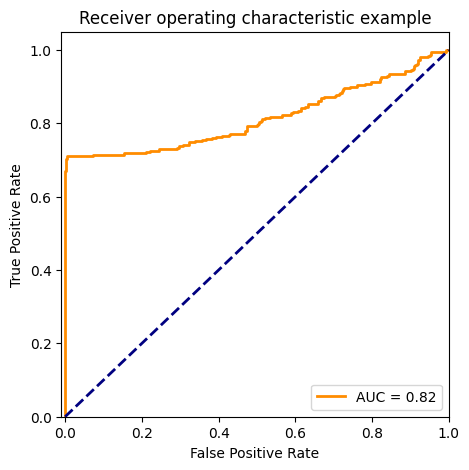

For a FPR approximately equals to 0.05 corresponds a TPR equals to 0.71
For a FPR approximately equals to 0.05 corresponds a threshold equals to 0.71
Check FPR 0.05
For a FPR approximately equals to 0.1 corresponds a TPR equals to 0.71
For a FPR approximately equals to 0.1 corresponds a threshold equals to 0.70
Check FPR 0.10


In [41]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

#compute ROC
fpr, tpr, tau = roc_curve(np.asarray(labels), np.asarray(scores), drop_intermediate=False)
#compute AUC
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
idx_tpr = np.where((fpr-0.05)==min(i for i in (fpr-0.05) if i > 0))
print('For a FPR approximately equals to 0.05 corresponds a TPR equals to %0.2f' % tpr[idx_tpr[0][0]])
print('For a FPR approximately equals to 0.05 corresponds a threshold equals to %0.2f' % tau[idx_tpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_tpr[0][0]])

idx_tpr = np.where((fpr-0.1)==min(i for i in (fpr-0.1) if i > 0))
print('For a FPR approximately equals to 0.1 corresponds a TPR equals to %0.2f' % tpr[idx_tpr[0][0]])
print('For a FPR approximately equals to 0.1 corresponds a threshold equals to %0.2f' % tau[idx_tpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_tpr[0][0]])

In [ ]:
import numpy as np
import matplotlib.pyplot as pltdata
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 5]

from sklearn.metrics import roc_curve, auc

marksCount = 5
imgs = [cv2.imread(os.path.join('./sample_imgs', img), 0) for img in os.listdir('./sample_imgs')]
imgs = imgs[:10]
num_images = len(imgs)


marks = [ np.random.choice([0, 1], 1024) for _ in range(marksCount) ]                
                        
                         
import concurrent.futures
import cv2
import numpy as np

def process_image(image, marks, marksCount, alpha=0.5, max_layer=2):
    results = []

    attacks = [
        ("none", lambda i: i.copy()),
        ("awgn", lambda i: awgn(i, 18, 1234)),
        ("blur", lambda i: blur(i, 1.2)),
        ("sharpening", lambda i: sharpening(i, 1, 1.0)),
        ("median", lambda i: median(i, [3, 5])),
        ("resizing", lambda i: resizing(i, 1/2)),
        ("jpeg", lambda i: jpeg_compression(i, 10))
    ]

    for i, signer in enumerate(marks):
        print(f'Signer #{i + 1}/{marksCount}')
        signed = embedding(image, signer, alpha, max_layer)

        for detector in marks:
            ok = 1 if np.array_equal(detector, signer) else 0
            signed2 = embedding(image, detector, alpha, max_layer=max_layer)
            _, score = detection(image, signed, signed2, alpha, max_layer)
            results.append((score, ok))
            
            for name, attack_func in attacks:
                att = attack_func(signed2)
                quality, sim = detection(image, signed, att, alpha, max_layer)
                if quality >= 35:
                    results.append((sim, ok))
                else:
                    print(f'{name} destroyed the image')
    
    return results



from concurrent.futures import ProcessPoolExecutor, as_completed
import traceback

def parallel_image_processing(marks, marksCount, num_images):
    results = []
    alpha = 0.5
    max_layer = 1

    # Use ThreadPoolExecutor or ProcessPoolExecutor depending on the task type
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(process_image, im, marks, marksCount, alpha, max_layer) for im in imgs]
        
        for future in as_completed(futures):
            try:
                image_results = future.result()
                results.extend(image_results)  # Collect the results
            except Exception:
                print(f"Generated an exception: {traceback.format_exc()}")

    return results


results = parallel_image_processing(marks, marksCount, imgs)

score, label = zip(*results)
score = list(score)
label = list(label)
        
#compute ROC
fpr, tpr, tau = roc_curve(label, score, drop_intermediate=False)

#compute AUC
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
idx_tpr = np.where((fpr-0.05)==min(i for i in (fpr-0.05) if i > 0))
print('For a FPR approximately equals to 0.05 corresponds a TPR equals to %0.2f' % tpr[idx_tpr[0][0]])
print('For a FPR approximately equals to 0.05 corresponds a threshold equals to %0.2f' % tau[idx_tpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_tpr[0][0]])